In [2]:
# 1. Install & Import
!pip install diffusers transformers accelerate torch torchvision bitsandbytes kaggle peft tqdm
import os
import torch
import pandas as pd
from google.colab import files, drive
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline
from diffusers.optimization import get_scheduler
from peft import LoraConfig, get_peft_model, PeftModel
import zipfile
from tqdm import tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [3]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Google Drive and Kaggle Setup
drive.mount('/content/drive')

print("Please upload your kaggle.json for Kaggle API access")
uploaded = files.upload()  # Upload kaggle.json

# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("--- Downloading Indian food images dataset ---")
!kaggle datasets download -d iamsouravbanerjee/indian-food-images-dataset -p /content/

# 3. Extract the dataset
print("--- Extracting dataset ---")
with zipfile.ZipFile('/content/indian-food-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Set the root directory of the Indian food images after extraction
indian_food_dir = '/content/Indian Food Images'

if not os.path.exists(indian_food_dir):
    raise FileNotFoundError(f"Dataset directory not found: {indian_food_dir}")

# --- 3. DATA PREPARATION ---

# The dataset path is 'Indian Food Images'
indian_food_dir = 'Indian Food Images/Indian Food Images'
indian_image_files = []
indian_captions = []

# Iterate through each food category in the Western directory
for category in os.listdir(indian_food_dir):
    category_path = os.path.join(indian_food_dir, category)
    if os.path.isdir(category_path):
        for img_file in os.listdir(category_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                indian_image_files.append(os.path.join(category, img_file))
                # Create a simple but effective caption
                caption = f"a photograph of {category.replace('_', ' ')}"
                indian_captions.append(caption)

# Create a DataFrame and save it to metadata.csv
metadata_df = pd.DataFrame({
    'file_name': indian_image_files,
    'caption': indian_captions
})
metadata_df.to_csv(os.path.join(indian_food_dir, 'metadata.csv'), index=False)

print(f"--- Created metadata.csv with {len(metadata_df)} entries for Indian food ---")

Mounted at /content/drive
Please upload your kaggle.json for Kaggle API access


Saving kaggle.json to kaggle.json
--- Downloading Indian food images dataset ---
Dataset URL: https://www.kaggle.com/datasets/iamsouravbanerjee/indian-food-images-dataset
License(s): other
 98% 349M/355M [00:00<00:00, 456MB/s]
100% 355M/355M [00:00<00:00, 545MB/s]
--- Extracting dataset ---
--- Created metadata.csv with 4000 entries for Indian food ---


In [4]:
metadata_df

,file_name,caption
0,paneer_butter_masala/23b8311940.jpg,a photograph of paneer butter masala
1,paneer_butter_masala/20ae9d2a5c.jpg,a photograph of paneer butter masala
2,paneer_butter_masala/7f025c87be.jpg,a photograph of paneer butter masala
3,paneer_butter_masala/0a40ebbe55.jpg,a photograph of paneer butter masala
4,paneer_butter_masala/3d42568539.jpg,a photograph of paneer butter masala
...,...,...
3995,modak/1adc11b705.jpg,a photograph of modak
3996,modak/0cf3efc19c.jpg,a photograph of modak
3997,modak/9a17b6b5fb.jpg,a photograph of modak
3998,modak/5d8b3dfcf6.jpg,a photograph of modak


In [11]:
metadata_df["caption"].unique()

array(['a photograph of paneer butter masala',
       'a photograph of aloo matar', 'a photograph of litti chokha',
       'a photograph of biryani', 'a photograph of kuzhi paniyaram',
       'a photograph of ras malai', 'a photograph of jalebi',
       'a photograph of adhirasam', 'a photograph of unni appam',
       'a photograph of dum aloo', 'a photograph of aloo methi',
       'a photograph of gajar ka halwa', 'a photograph of dal tadka',
       'a photograph of pootharekulu', 'a photograph of chana masala',
       'a photograph of chicken tikka', 'a photograph of bhindi masala',
       'a photograph of chicken razala', 'a photograph of poha',
       'a photograph of malapua', 'a photograph of dharwad pedha',
       'a photograph of navrattan korma',
       'a photograph of chicken tikka masala',
       'a photograph of shrikhand', 'a photograph of sheera',
       'a photograph of butter chicken', 'a photograph of rabri',
       'a photograph of chikki', 'a photograph of aloo shim

In [26]:
# 5. Dataset class for loading images and captions
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from collections import Counter

class FoodDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, max_samples=None, samples_per_class=20):
        self.full_df = metadata_df  # Keep the original metadata_df reference
        self.image_dir = image_dir
        self.transform = transform
        self.samples_per_class = samples_per_class

        # Balance the dataset first
        self.captions_df = self._balance_dataset()

        # Apply max_samples if specified (after balancing)
        if max_samples:
            self.captions_df = self.captions_df.head(max_samples)

        print(f"Dataset balanced with {self.samples_per_class} samples per class")
        print(f"Total samples after balancing: {len(self.captions_df)}")

    def _balance_dataset(self):
        """Balance the dataset to have equal samples per class"""
        balanced_dfs = []

        # Group by caption (assuming caption is in column 1)
        grouped = self.full_df.groupby(self.full_df.columns[1])

        for caption, group in grouped:
            if len(group) >= self.samples_per_class:
                # If we have enough samples, randomly sample the required number
                sampled_group = group.sample(n=self.samples_per_class, random_state=42)
            else:
                # If we don't have enough samples, use all available and duplicate if needed
                sampled_group = group.copy()
                remaining_needed = self.samples_per_class - len(group)

                if remaining_needed > 0:
                    # Duplicate samples to reach the target
                    duplicates = group.sample(n=remaining_needed, replace=True, random_state=42)
                    sampled_group = pd.concat([sampled_group, duplicates], ignore_index=True)

            balanced_dfs.append(sampled_group)

        # Combine all balanced groups
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)

        # Shuffle the final dataset
        balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

        return balanced_df

    def get_class_distribution(self):
        """Get the distribution of classes in the balanced dataset"""
        return Counter(self.captions_df.iloc[:, 1])  # Assuming caption is in column 1

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        try:
            img_path = os.path.join(self.image_dir, self.captions_df.iloc[idx, 0])
            if not os.path.exists(img_path):
                print(f"Image not found: {img_path}")
                image = Image.new('RGB', (512, 512), color='white')  # fallback white image
            else:
                image = Image.open(img_path).convert("RGB")
            caption = self.captions_df.iloc[idx, 1]
            if self.transform:
                image = self.transform(image)
            return {"image": image, "caption": caption}
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            image = torch.zeros(3, 512, 512)
            caption = "fallback image"
            return {"image": image, "caption": caption}

# 6. Transformations (resize, crop, normalize)
preprocess = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Load dataset and dataloader
metadata_path = metadata_df

train_dataset = FoodDataset(metadata_path, indian_food_dir, transform=preprocess )
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
print(f"Training dataset size: {len(train_dataset)}")

# 7. Model loading and configuration
pretrained_model_name = "runwayml/stable-diffusion-v1-5"
output_dir = "/content/drive/MyDrive/CravingsGenerator/Indian_model"
os.makedirs(output_dir, exist_ok=True)

learning_rate = 1e-4
num_train_epochs = 5
gradient_accumulation_steps = 4

print("--- Loading Stable Diffusion model ---")
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16,
    use_safetensors=True,
).to(device)

tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder.to(device)
vae = pipeline.vae.to(device)
unet = pipeline.unet.to(device)
noise_scheduler = pipeline.scheduler

# 8. LoRA setup
print("--- Setting up LoRA adapters ---")
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
        "to_k", "to_q", "to_v", "to_out.0",
        "proj_in", "proj_out",
        "ff.net.0.proj", "ff.net.2",
        "conv1", "conv2", "conv_shortcut",
        "time_emb_proj"
    ],
    lora_dropout=0.1,
    bias="none"
)

unet = get_peft_model(unet, lora_config)
unet.train()

trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# 9. Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_dataloader) * num_train_epochs,
)

# 10. Training loop with tqdm progress bar and checkpoint saving
print("--- Starting Fine-Tuning ---")
global_step = 0
for epoch in range(num_train_epochs):
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_train_epochs}")

    for step, batch in enumerate(progress_bar):
        images = batch["image"].to(device, dtype=torch.float16)
        captions = batch["caption"]

        with torch.no_grad():
            latents = vae.encode(images).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            text_inputs = tokenizer(
                captions,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            )
            text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]

        noise = torch.randn_like(latents)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (latents.shape[0],),
            device=latents.device
        ).long()

        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
        noise_pred = unet(noisy_latents, timesteps, text_embeddings, return_dict=False)[0]

        loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float(), reduction="mean")
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            global_step += 1

        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item(), "lr": lr_scheduler.get_last_lr()[0]})

        if global_step % 200 == 0 and global_step > 0:
            checkpoint_dir = os.path.join(output_dir, f"checkpoint-{global_step}")
            os.makedirs(checkpoint_dir, exist_ok=True)
            unet.save_pretrained(checkpoint_dir)
            print(f"Checkpoint saved at step {global_step}")

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")


# 11. Save the final model and all components
print("--- Saving final model ---")
final_model_dir = os.path.join(output_dir, "final_model")
os.makedirs(final_model_dir, exist_ok=True)

unet.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)
text_encoder.save_pretrained(final_model_dir)
vae.save_pretrained(final_model_dir)
noise_scheduler.save_pretrained(final_model_dir)

import json
training_info = {
    "base_model": pretrained_model_name,
    "epochs": num_train_epochs,
    "learning_rate": learning_rate,
    "dataset_size": len(train_dataset),
    "lora_r": 16,
    "lora_alpha": 16
}

with open(os.path.join(final_model_dir, "training_info.json"), "w") as f:
    json.dump(training_info, f, indent=2)

print(f"Fine-tuning complete! Model saved to {final_model_dir}")


Dataset balanced with 20 samples per class
Total samples after balancing: 1600
Training dataset size: 1600
--- Loading Stable Diffusion model ---


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

--- Setting up LoRA adapters ---
Trainable parameters: 15,942,656
--- Starting Fine-Tuning ---


Epoch 1/5:  50%|█████     | 800/1600 [06:32<08:13,  1.62it/s, loss=0.442, lr=9.87e-5]

Checkpoint saved at step 200


Epoch 1/5:  50%|█████     | 801/1600 [06:33<10:44,  1.24it/s, loss=0.042, lr=9.87e-5]

Checkpoint saved at step 200


Epoch 1/5:  50%|█████     | 802/1600 [06:37<22:56,  1.73s/it, loss=0.0713, lr=9.87e-5]

Checkpoint saved at step 200


Epoch 1/5:  50%|█████     | 803/1600 [06:43<39:02,  2.94s/it, loss=0.401, lr=9.87e-5]

Checkpoint saved at step 200


Epoch 1/5: 100%|██████████| 1600/1600 [13:14<00:00,  1.14it/s, loss=0.121, lr=9.62e-5]

Checkpoint saved at step 400


Epoch 1/5: 100%|██████████| 1600/1600 [13:14<00:00,  2.01it/s, loss=0.121, lr=9.62e-5]


Epoch 1 completed. Average loss: 0.1631


Epoch 2/5:   0%|          | 1/1600 [00:01<51:50,  1.95s/it, loss=0.216, lr=9.62e-5]

Checkpoint saved at step 400


Epoch 2/5:   0%|          | 2/1600 [00:02<37:46,  1.42s/it, loss=0.143, lr=9.62e-5]

Checkpoint saved at step 400


Epoch 2/5:   0%|          | 3/1600 [00:06<59:56,  2.25s/it, loss=0.275, lr=9.62e-5]

Checkpoint saved at step 400


Epoch 2/5:  50%|█████     | 800/1600 [06:37<13:36,  1.02s/it, loss=0.364, lr=9.37e-5]

Checkpoint saved at step 600


Epoch 2/5:  50%|█████     | 801/1600 [06:41<23:19,  1.75s/it, loss=0.519, lr=9.37e-5]

Checkpoint saved at step 600


Epoch 2/5:  50%|█████     | 802/1600 [06:43<26:07,  1.96s/it, loss=0.0828, lr=9.37e-5]

Checkpoint saved at step 600


Epoch 2/5:  50%|█████     | 803/1600 [06:50<43:02,  3.24s/it, loss=0.0236, lr=9.37e-5]

Checkpoint saved at step 600


Epoch 2/5: 100%|██████████| 1600/1600 [13:23<00:00,  1.51s/it, loss=0.0425, lr=9.11e-5]

Checkpoint saved at step 800


Epoch 2/5: 100%|██████████| 1600/1600 [13:23<00:00,  1.99it/s, loss=0.0425, lr=9.11e-5]


Epoch 2 completed. Average loss: 0.1623


Epoch 3/5:   0%|          | 1/1600 [00:01<41:26,  1.56s/it, loss=0.0372, lr=9.11e-5]

Checkpoint saved at step 800


Epoch 3/5:   0%|          | 2/1600 [00:04<1:10:51,  2.66s/it, loss=0.221, lr=9.11e-5]

Checkpoint saved at step 800


Epoch 3/5:   0%|          | 3/1600 [00:05<49:23,  1.86s/it, loss=0.0297, lr=9.11e-5]  

Checkpoint saved at step 800


Epoch 3/5:  50%|█████     | 800/1600 [06:40<18:15,  1.37s/it, loss=0.324, lr=8.86e-5]

Checkpoint saved at step 1000


Epoch 3/5:  50%|█████     | 801/1600 [06:42<21:54,  1.65s/it, loss=0.417, lr=8.86e-5]

Checkpoint saved at step 1000


Epoch 3/5:  50%|█████     | 802/1600 [06:44<22:50,  1.72s/it, loss=0.00397, lr=8.86e-5]

Checkpoint saved at step 1000


Epoch 3/5:  50%|█████     | 803/1600 [06:49<35:41,  2.69s/it, loss=0.123, lr=8.86e-5]

Checkpoint saved at step 1000


Epoch 3/5: 100%|██████████| 1600/1600 [13:28<00:00,  2.40s/it, loss=0.157, lr=8.61e-5]

Checkpoint saved at step 1200


Epoch 3/5: 100%|██████████| 1600/1600 [13:28<00:00,  1.98it/s, loss=0.157, lr=8.61e-5]


Epoch 3 completed. Average loss: 0.1816


Epoch 4/5:   0%|          | 1/1600 [00:03<1:27:14,  3.27s/it, loss=0.23, lr=8.61e-5]

Checkpoint saved at step 1200


Epoch 4/5:   0%|          | 2/1600 [00:04<49:20,  1.85s/it, loss=0.0779, lr=8.61e-5]  

Checkpoint saved at step 1200


Epoch 4/5:   0%|          | 3/1600 [00:05<37:31,  1.41s/it, loss=0.00315, lr=8.61e-5]

Checkpoint saved at step 1200


Epoch 4/5:  50%|█████     | 800/1600 [06:43<33:58,  2.55s/it, loss=0.21, lr=8.35e-5]

Checkpoint saved at step 1400


Epoch 4/5:  50%|█████     | 801/1600 [06:45<31:26,  2.36s/it, loss=0.0699, lr=8.35e-5]

Checkpoint saved at step 1400


Epoch 4/5:  50%|█████     | 802/1600 [06:46<27:27,  2.06s/it, loss=0.552, lr=8.35e-5]

Checkpoint saved at step 1400


Epoch 4/5:  50%|█████     | 803/1600 [06:53<46:55,  3.53s/it, loss=0.00737, lr=8.35e-5]

Checkpoint saved at step 1400


Epoch 4/5: 100%|██████████| 1600/1600 [13:31<00:00,  2.64s/it, loss=0.0514, lr=8.1e-5]

Checkpoint saved at step 1600


Epoch 4/5: 100%|██████████| 1600/1600 [13:31<00:00,  1.97it/s, loss=0.0514, lr=8.1e-5]


Epoch 4 completed. Average loss: 0.1752


Epoch 5/5:   0%|          | 1/1600 [00:01<41:05,  1.54s/it, loss=0.138, lr=8.1e-5]

Checkpoint saved at step 1600


Epoch 5/5:   0%|          | 2/1600 [00:02<34:00,  1.28s/it, loss=0.0305, lr=8.1e-5]

Checkpoint saved at step 1600


Epoch 5/5:   0%|          | 3/1600 [00:03<29:44,  1.12s/it, loss=0.054, lr=8.1e-5]

Checkpoint saved at step 1600


Epoch 5/5:  50%|█████     | 800/1600 [06:35<13:56,  1.05s/it, loss=0.458, lr=7.85e-5]

Checkpoint saved at step 1800


Epoch 5/5:  50%|█████     | 801/1600 [06:40<28:11,  2.12s/it, loss=0.0588, lr=7.85e-5]

Checkpoint saved at step 1800


Epoch 5/5:  50%|█████     | 802/1600 [06:41<24:03,  1.81s/it, loss=0.609, lr=7.85e-5]

Checkpoint saved at step 1800


Epoch 5/5:  50%|█████     | 803/1600 [06:45<33:05,  2.49s/it, loss=0.681, lr=7.85e-5]

Checkpoint saved at step 1800


Epoch 5/5: 100%|██████████| 1600/1600 [13:17<00:00,  1.65it/s, loss=0.0156, lr=7.59e-5]

Checkpoint saved at step 2000


Epoch 5/5: 100%|██████████| 1600/1600 [13:18<00:00,  2.00it/s, loss=0.0156, lr=7.59e-5]


Epoch 5 completed. Average loss: 0.1691
--- Saving final model ---
Fine-tuning complete! Model saved to /content/drive/MyDrive/CravingsGenerator/Indian_model/final_model


--- Testing model generation ---


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Test image saved to: /content/drive/MyDrive/CravingsGenerator/Indian_model/test_generation.png


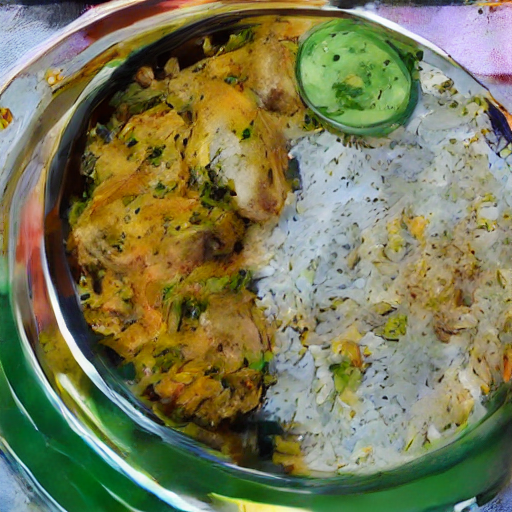

In [29]:
# 12. Test generation to verify fine-tuning
print("--- Testing model generation ---")
try:
    test_pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name,
        torch_dtype=torch.float16
    ).to(device)

    # Reapply LoRA weights for inference
    # Load the adapter model state dict
    drive.mount('/content/drive')
    output_dir = "/content/drive/MyDrive/CravingsGenerator/Indian_model"
    final_model_dir = os.path.join(output_dir, "final_model")
    adapter_model_path = os.path.join(final_model_dir, "adapter_model.safetensors")
    if not os.path.exists(adapter_model_path):
        raise FileNotFoundError(f"Adapter model not found: {adapter_model_path}")

    # Get the PEFT model for the unet
    test_unet = get_peft_model(test_pipeline.unet, lora_config)

    # Load the adapter weights into the PEFT model
    from peft import PeftModel # Using PeftModel instead of PeftModelForLora
    test_unet = PeftModel.from_pretrained(test_pipeline.unet, final_model_dir)

    test_unet.eval()
    test_pipeline.unet = test_unet

    prompt = "a photograph of chicken biriyani"
    image = test_pipeline(prompt, num_inference_steps=20, guidance_scale=7.5).images[0]

    test_image_path = os.path.join(output_dir, "test_generation.png")
    image.save(test_image_path)
    print(f"Test image saved to: {test_image_path}")

    from IPython.display import Image as IPImage, display
    display(IPImage(test_image_path))
except Exception as e:
    print(f"Error during test generation: {e}")